In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('../')

In [5]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [6]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [7]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [8]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Load Datasets

In [9]:
pretrained = True
freeze = False
num_classes = 200
num_attributes = 13
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [10]:
BASE_DIR = ""
data_dir_small = "../cem/cem/CUB_small/preprocessed/"
data_dir_blur = "../cem/cem/CUB_blur/preprocessed/"
data_dir_tag = "../cem/cem/CUB_tag/preprocessed/"

In [11]:
train_data_path = os.path.join(BASE_DIR, data_dir_small, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')

In [12]:
train_loader_small = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader_small = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [13]:
train_data_path = os.path.join(BASE_DIR, data_dir_blur, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')

In [14]:
train_loader_blur = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader_blur = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [15]:
train_data_path = os.path.join(BASE_DIR, data_dir_tag, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')

In [16]:
train_loader_tag = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path,is_training=False)
val_loader_tag = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

## Load Models

In [17]:
joint_location_small = "ConceptBottleneck/results/CUB_small/joint_unknown/best_model_42.pth"
joint_model_small = torch.load(joint_location_small,map_location=torch.device('cpu'))
r = joint_model_small.eval()

In [18]:
joint_location_blur = "ConceptBottleneck/results/CUB_blur/joint_unknown/best_model_42.pth"
joint_model_blur = torch.load(joint_location_blur,map_location=torch.device('cpu'))
r = joint_model_blur.eval()

In [19]:
joint_location_tag = "ConceptBottleneck/results/CUB_tag/joint_unknown/best_model_42.pth"
joint_model_tag = torch.load(joint_location_tag,map_location=torch.device('cpu'))
r = joint_model_tag.eval()

## Evalaute Models

In [25]:
get_accuracy(joint_model_small,run_joint_model,val_loader_small)

tensor(0.9420)

In [26]:
get_accuracy(joint_model_blur,run_joint_model,val_loader_blur)

tensor(0.9275)

In [27]:
get_accuracy(joint_model_tag,run_joint_model,val_loader_tag)

tensor(0.8841)

In [28]:
score = spurious_score(joint_model_blur,run_joint_model,'blur',val_loader_small,0)
score

tensor(1.)

In [29]:
score = spurious_score(joint_model_small,run_joint_model,'blur',val_loader_small,0)
score

tensor(0.1692)

In [30]:
score = spurious_score(joint_model_tag,run_joint_model,'tag',val_loader_small,0)
score

tensor(1.)

In [31]:
score = spurious_score(joint_model_small,run_joint_model,'tag',val_loader_small,0)
score

tensor(0.)

## Analyze Important Nodes

In [20]:
x_small = []

for idx,i in enumerate(train_loader_small):
    x,y,c = i
    x_small.append(x)
    
x_small = torch.cat(x_small,dim=0)

In [21]:
pil_images = [transforms.ToPILImage()(x_small[j]) for j in range(x_small.shape[0])]
transformed_images = [transforms.ToTensor()(add_blur_array(image)) for image in pil_images]
transformed_images = [normalize_tensor(image)
                      for image in transformed_images]
blur_images = torch.stack(transformed_images)

In [20]:
pil_images = [transforms.ToPILImage()(x_small[j]) for j in range(x_small.shape[0])]
transformed_images = [transforms.ToTensor()(add_tag_array(image)) for image in pil_images]
transformed_images = [normalize_tensor(image)
                      for image in transformed_images]
tag_images = torch.stack(transformed_images)

In [103]:
y_pred_small, c_pred_small = run_joint_model(joint_model_small,blur_images)
logits_to_index(y_pred_small)

tensor([ 7,  2,  0,  5,  2,  1,  2,  4,  1,  9, 10,  0,  0, 10,  2,  0,  8, 10,
         0,  0,  6,  8,  7,  0,  1,  3,  0,  1,  3,  1,  3, 10,  2,  0,  8,  0,
        10,  0,  2,  2,  4,  1,  1,  7,  2,  0, 10,  3,  2,  2,  8,  2,  6,  8,
         0, 10, 10,  1,  4,  2,  2, 10, 10,  2,  8,  3,  1,  6,  8,  0,  8, 10,
         2,  1,  0,  2,  1,  2, 10,  1, 10,  0,  2,  5,  2,  1,  1,  2,  3,  0,
         2,  6,  2,  3,  2,  8,  4,  8, 10,  8, 10, 10,  6,  1,  0,  0,  8, 10,
         2,  0,  2,  0,  3,  1,  0,  1, 10, 10,  3,  9,  1,  2,  2,  2,  2,  0,
         1,  8,  8, 10,  6,  5,  3,  7,  1, 10,  1, 10,  2,  6,  5, 10,  2,  1,
         1,  1,  3,  0,  1,  0,  2,  0,  2,  0,  2,  1,  2,  3, 10,  3,  2,  8,
         1,  5,  2, 10,  1,  4,  0,  3,  0,  2, 10,  5,  2,  1,  1,  1,  0,  8,
         2, 10, 10, 10,  2,  2,  0,  3,  9,  7,  2,  4,  5,  4,  8,  2,  0,  0,
         8,  1,  2,  8,  4,  4, 10,  2,  2,  2,  0,  8,  8,  4,  3,  3, 10,  2,
         1,  2,  0, 10,  6,  7, 10,  2, 

In [ ]:
y_pred_blur, c_pred_blur = run_joint_model(joint_model_blur,blur_images)
logits_to_index(y_pred_blur)

In [ ]:
y_pred_tag, c_pred_tag = run_joint_model(joint_model_tag,tag_images)
logits_to_index(y_pred_tag)

In [21]:
weights_small, c_pred_small = get_attribute_class_weights(joint_model_small,run_joint_model,joint_model_small.sec_model.linear.weight,blur_images)

In [22]:
weights_blur, c_pred_blur = get_attribute_class_weights(joint_model_blur,run_joint_model,joint_model_blur.sec_model.linear.weight,blur_images)

In [23]:
weights_tag, c_pred_tag = get_attribute_class_weights(joint_model_tag,run_joint_model,joint_model_tag.sec_model.linear.weight,tag_images)

In [ ]:
np.argsort(weights_small[0,:,0].detach().numpy())[::-1]

In [ ]:
np.argsort(weights_blur[0,:,0].detach().numpy())[::-1]

In [ ]:
np.argsort(weights_tag[0,:,0].detach().numpy())[::-1]

[1.077500343322754, 0.9846883416175842, 0.5418652892112732, 0.45457616448402405, 0.4420119822025299, -0.03196258842945099] ['has_upperp (#12)', 'has_head_p (#37)', 'has_upperp (#10)', 'has_throat (#47)', 'has_belly_ (#71)', 'Extra Node (#112)']


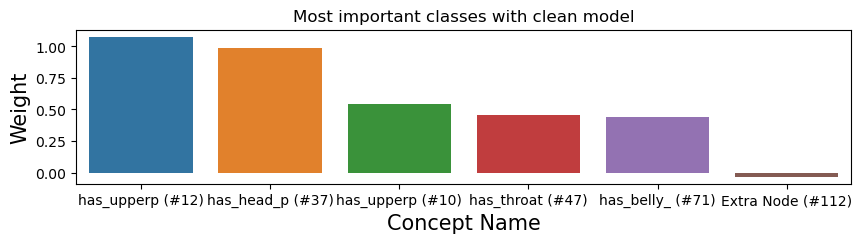

In [72]:
plt.figure(figsize=(10,2))
plt.title("Most important classes with clean model")
plt.xlabel("Concept Name",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plot_most_important_classes(weights_small,CUB_ATTRIBUTES,add_extra_node=True)

[1.2351447343826294, 0.8995088934898376, 0.6458944082260132, 0.5376970767974854, 0.4860812723636627, 0.10707662254571915] ['has_upperp (#10)', 'has_head_p (#37)', 'has_wing_c (#9)', 'has_upperp (#12)', 'has_belly_ (#71)', 'Extra Node (#112)']


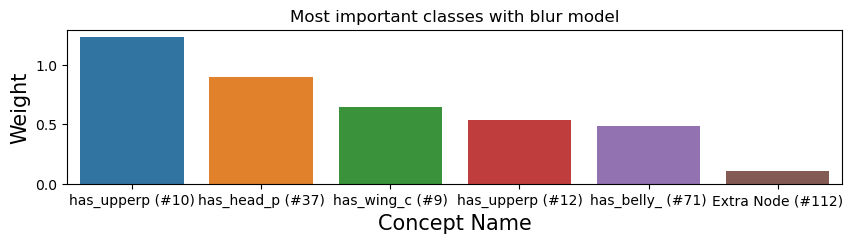

In [73]:
plt.figure(figsize=(10,2))
plt.title("Most important classes with blur model")
plt.xlabel("Concept Name",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plot_most_important_classes(weights_blur,CUB_ATTRIBUTES,add_extra_node=True)

[1.143454670906067, 1.123699426651001, 1.0932977199554443, 0.9796398282051086, 0.7034518122673035, 0.10954683274030685] ['has_upperp (#10)', 'has_breast (#23)', 'has_head_p (#37)', 'has_upperp (#12)', 'has_bill_s (#0)', 'Extra Node (#112)']


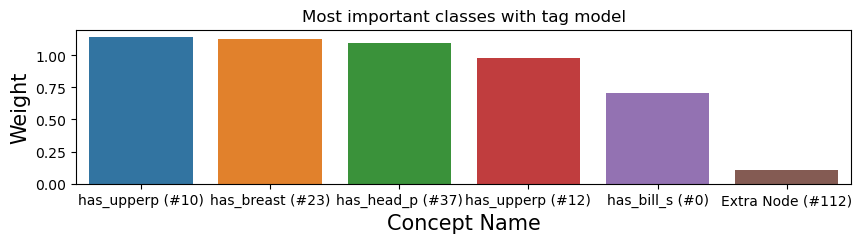

In [74]:
plt.figure(figsize=(10,2))
plt.title("Most important classes with tag model")
plt.xlabel("Concept Name",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plot_most_important_classes(weights_tag,CUB_ATTRIBUTES,add_extra_node=True)

<AxesSubplot:title={'center':'Importance of extra node'}>

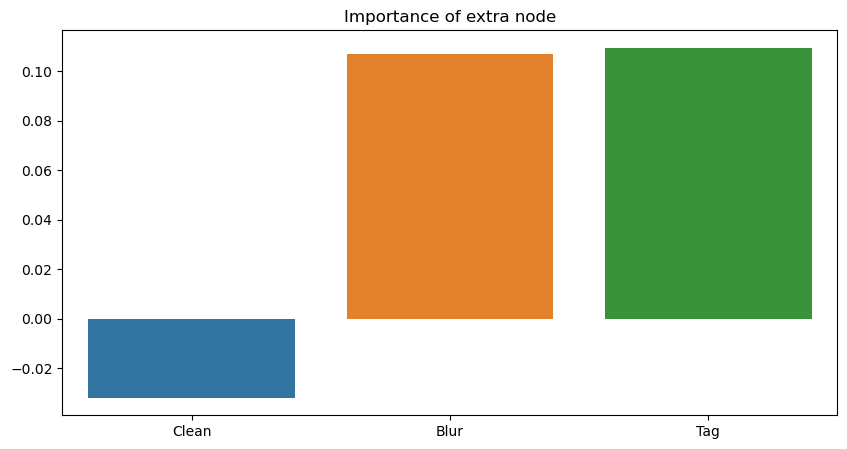

In [43]:
plt.figure(figsize=(10,5))
plt.title("Importance of extra node")
labels = ["Clean","Blur","Tag"]
weights = [float(torch.mean(w[0,-1,:])) for w in [weights_small,weights_blur,weights_tag]]
sns.barplot(x=labels, y=weights)

In [48]:
avg_weights_by_method = [sorted(torch.mean(w[0,:,:],dim=1).detach().numpy())[::-1] for w in [weights_small, weights_blur, weights_tag]]
labels = ['Clean', 'Blur','Tag']

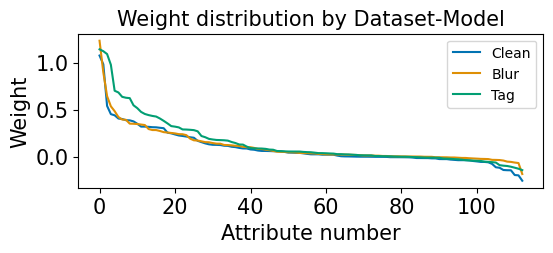

In [63]:
plt.figure(figsize=(6,2))
plt.title("Weight distribution by Dataset-Model",fontsize=15)
plt.xlabel("Attribute number",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i in range(len(labels)):
    plt.plot(avg_weights_by_method[i],label=labels[i],c=colors[i])
plt.legend()

## Are there other features that differ between spurious/non-spurious?

### Let's train an SVM to prediction

In [24]:
batch_size = weights_small.shape[-1]

X_train = torch.cat([w[0,:,:round(0.8*batch_size)] for w in [weights_small,weights_blur,weights_tag]],dim=1)
X_train = X_train.detach().numpy().T
X_test =  torch.cat([w[0,:,round(0.8*batch_size):] for w in [weights_small,weights_blur,weights_tag]],dim=1)
X_test = X_test.detach().numpy().T
Y_train = [0 for i in range(round(0.8*batch_size))] + [1 for i in range(round(0.8*batch_size)*2)]
Y_test = [0 for i in range(batch_size-round(0.8*batch_size))] + [1 for i in range((batch_size-round(0.8*batch_size))*2)]

In [29]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression()

In [30]:
score = lr.score(X_test, Y_test)
score

1.0

In [35]:
coef = lr.coef_[0]

In [38]:
coef

array([ 1.52367171e+00, -1.42859037e-01,  7.07824028e-01, -1.01918438e+00,
        9.27881369e-02,  2.67082058e-01, -7.29446231e-02,  9.53887751e-01,
       -1.96772213e-01,  6.24537680e-01,  2.41299125e+00, -2.87190340e-01,
       -1.72218435e+00,  4.41715158e-01, -6.76694531e-01,  1.19131105e+00,
        6.71595929e-01, -4.74542434e-01, -1.58747975e-02,  4.88625380e-01,
        1.22143207e-01, -2.55843717e-01, -1.07543033e-01,  5.45510988e-01,
        2.33407305e-01, -2.62328025e-02, -1.23646339e-01,  1.52322499e-01,
        1.13967735e+00,  5.38372920e-02,  1.75888366e-01, -9.59546936e-02,
       -7.34905636e-01, -3.78026684e-01,  1.33566285e+00,  1.42382173e-01,
        5.02433089e-01, -2.77801488e-01, -1.48032463e-01,  2.09914097e-01,
       -1.20779759e-01, -2.42723161e-01,  1.88786591e-01, -1.93547443e-01,
        7.63365269e-02,  3.70532808e-01, -1.88694915e-01, -4.29187081e-01,
        4.91812201e-01,  1.32509427e-01, -3.49579090e-01, -9.89465109e-02,
       -6.44101349e-02, -

In [39]:
np.argsort(np.abs(coef))[::-1]

array([ 10,  12, 110,   0,  34,  15,  28,  69,  65,  78,   3,   7,  80,
        76, 100,  79,  32,  61,  77,  90,   2,  14,  16,  86,   9, 112,
        62, 101,  91,  23, 106,  36,  48,  19,  72,  17,  94,  57,  13,
        47, 104,  33,  45,  87, 108,  59, 102,  50,  75,  81,  92,  55,
        11,  37,  64,   5,  21,  54,  41, 103,  24,  82,  39,  97,   8,
        43,  98,  42,  46,  73,  30,  71,  93,  27,  99,  53,  38,   1,
        35,  74,  67,  49,  88,  26,  20,  40,  22,  51,  58,  31,   4,
       105, 111,  68,  44,   6,  66,  52,  96,  29,  63, 109,  56,  95,
        70,  84, 107,  25,  18,  60,  89,  83,  85])

### Why is Concept 10 so important? 

In [64]:
a = pickle.load(open("../cem/cem/CUB_small/preprocessed_unknown/train.pkl","rb"))

In [70]:
[i['class_label'] for i in a if i['attribute_label'][10]]

[]

CBMs use any extra space available to store their information, not necesarily the space we allocate. This is almost a problem with too many concepts, as the extra concepts will simply encode for the task. 

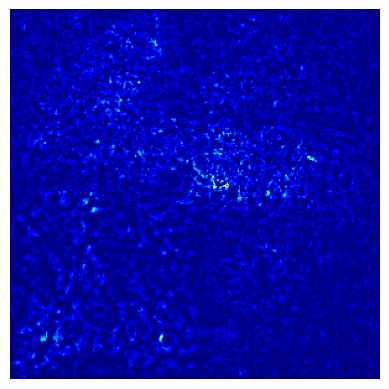

In [24]:
plot_saliency(joint_model_small,run_joint_model,112,blur_images)

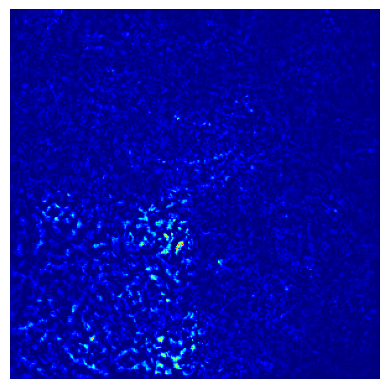

In [23]:
plot_saliency(joint_model_blur,run_joint_model,112,blur_images)